## Notebook Purpose

now that dd+ has been drastically simplified/streamlined in qdess expmt, make this compatible for fastmri expmts

In [45]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5#, load_output, save_output, \
from utils.helpers import num_params#, get_masks
from include.decoder_conv import init_convdecoder
from include.fit import fit
from include.subsample import MaskFunc
from utils.evaluate import calc_metrics
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals, \
                            crop_center

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(2)
else:
    dtype = torch.FloatTensor

In [46]:
def plot_list(arr_list):
    
    NUM_COLS = len(arr_list)
    title_list = ['gt', 'est', 'dc']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx])
        ax.axis('off')
    plt.show()

### Run expmts

In [47]:
file_id = '1001798' #'1000273'
f, ksp_orig = load_h5(file_id)

ksp_orig = torch.from_numpy(ksp_orig)
ksp_orig.shape, ksp_orig.mean()

(torch.Size([15, 640, 372]), tensor(-3.7482e-09+2.1865e-09j))

### want mask to be 1d, length 372

(nc, kx, ky) = (15, 640, 372). want to fully sample kx and undersample ky

In [48]:
def get_mask(ksp_orig, center_fractions=[0.07], accelerations=[4]):
    ''' simplified version of get_masks() in utils.helpers -- return only a 1d mask in torch tensor '''
        
    mask_func = MaskFunc(center_fractions=center_fractions, \
                             accelerations=accelerations)
    
    # note: had to swap dims to be compatible w facebook's MaskFunc class
    mask_shape = (1, ksp_orig.shape[2], ksp_orig.shape[1])
    
    mask = mask_func(mask_shape, seed=0)

    return mask[0,:,0].type(torch.uint8)

In [49]:
mask = get_mask(ksp_orig)
mask.shape

torch.Size([372])

### init network

In [75]:
net, net_input, ksp_orig_ = init_convdecoder(ksp_orig, mask)

### apply mask

In [133]:
ksp_orig__ = 1.0*ksp_orig_ #40000000 * ksp_orig

In [140]:
(0.1*ksp_orig_).mean(), ksp_orig__.mean()

(tensor(-0.0336+0.0196j), tensor(-0.3360+0.1960j))

In [141]:
ksp_masked = ksp_orig_ * mask # should be ksp_orig_
img_masked = ifft_2d(ksp_masked)

ksp_orig.shape, ksp_masked.shape, img_masked.shape

(torch.Size([15, 640, 372]),
 torch.Size([15, 640, 372]),
 torch.Size([15, 640, 372]))

In [142]:
net, mse_wrt_ksp, mse_wrt_img = fit(
    ksp_masked=ksp_masked, img_masked=img_masked,
    net=net, net_input=net_input, mask2d=mask, num_iter=1000)

In [143]:
img_out = net(net_input.type(dtype))[0]
img_out.shape, img_out.dtype

(torch.Size([30, 640, 372]), torch.float32)

on qdess issue: network output has .mean() ~2, while gt has .mean() ~20000

In [144]:
# make complex tensor [nc,x,y] from [2*nc,x,y]
img_out = reshape_adj_channels_to_complex_vals(img_out)

ksp_est = fft_2d(img_out)

# apply dc step
ksp_dc = torch.where(mask, ksp_masked, ksp_est) 

In [145]:
dim = 320

img_est = crop_center(root_sum_squares(ifft_2d(ksp_est)).detach(), dim, dim)
img_dc = crop_center(root_sum_squares(ifft_2d(ksp_dc)).detach(), dim, dim)
img_gt = crop_center(root_sum_squares(ifft_2d(ksp_orig)), dim, dim)

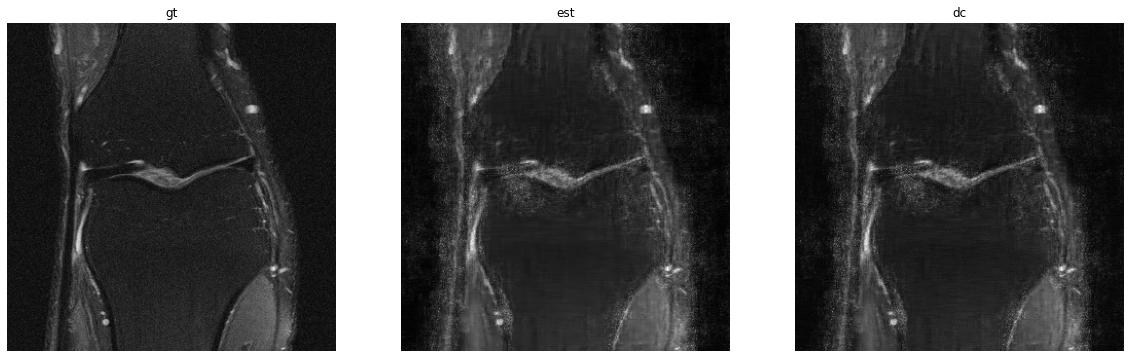

In [148]:
# when i do ksp_orig_ ~= 96e6 * ksp_orig, i.e. original
plot_list([img_gt, img_est, img_dc])

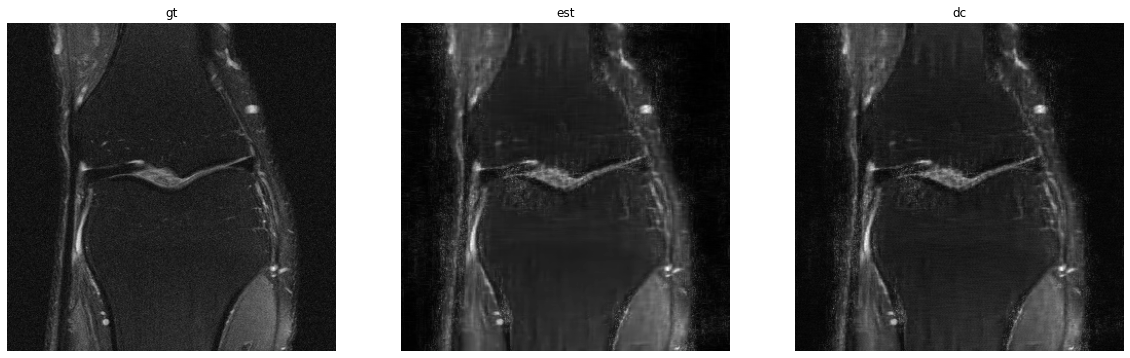

In [139]:
# when i do 1.0 * ksp_orig_ ~= 96e6 * ksp_orig, i.e. original
plot_list([img_gt, img_est, img_dc])

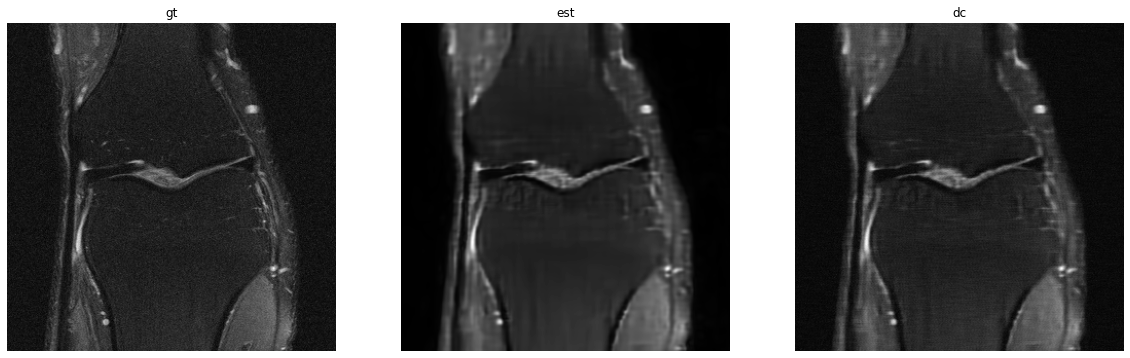

In [132]:
# when i do 0.5 * ksp_orig_ ~= 48e6 * ksp_orig instead of 96e6 * ksp_orig
plot_list([img_gt, img_est, img_dc])

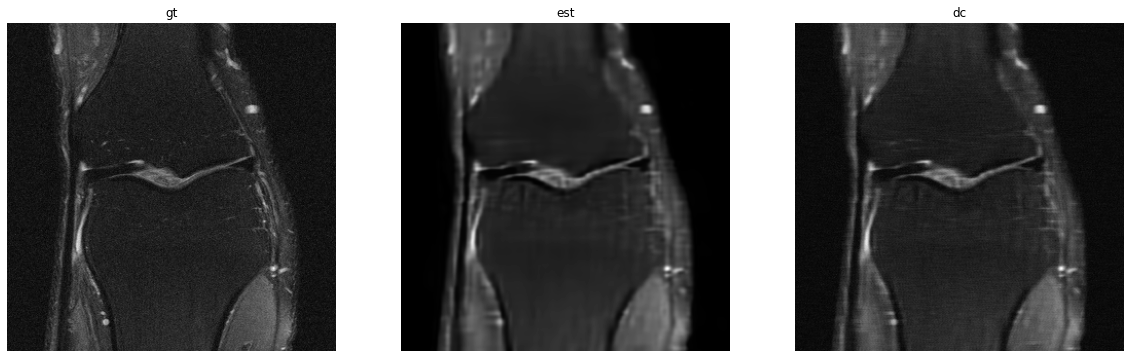

In [125]:
# when i do ksp_orig__ = 40e6 * ksp_orig instead of 96e6 * ksp_orig
plot_list([img_gt, img_est, img_dc])

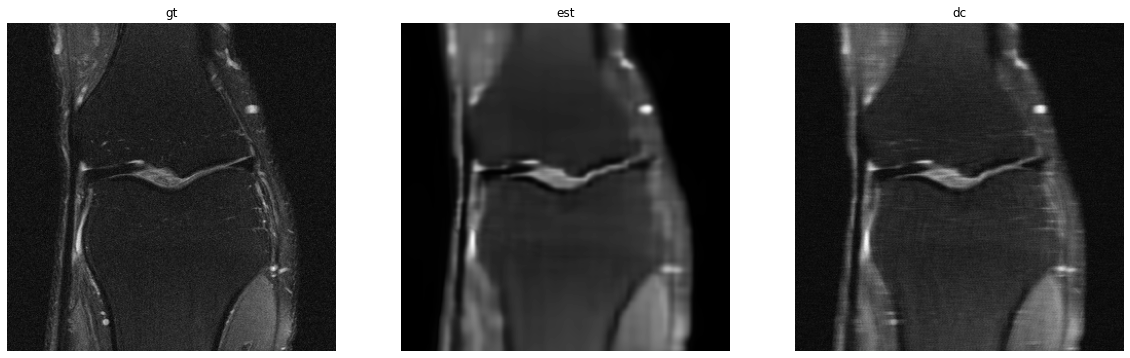

In [110]:
# when i do ksp_orig__ = 20e6 * ksp_orig instead of 96e6 * ksp_orig
plot_list([img_gt, img_est, img_dc])

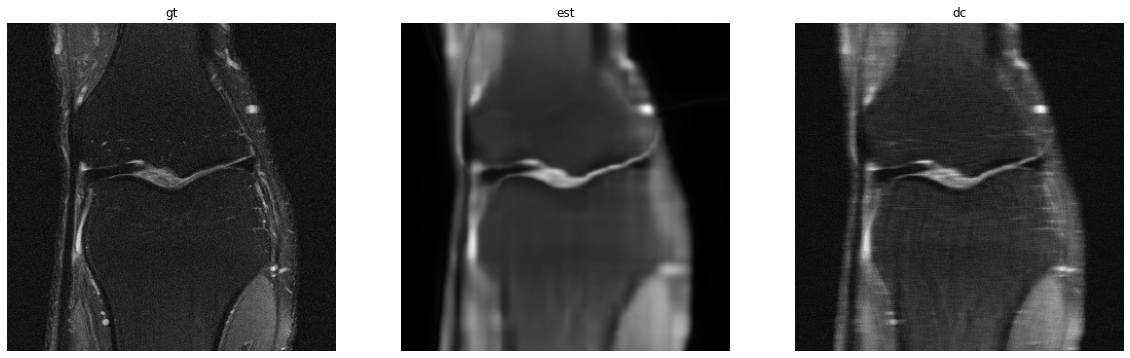

In [100]:
# when i do ksp_orig__ = 10e6 * ksp_orig instead of 96e6 * ksp_orig
plot_list([img_gt, img_est, img_dc])

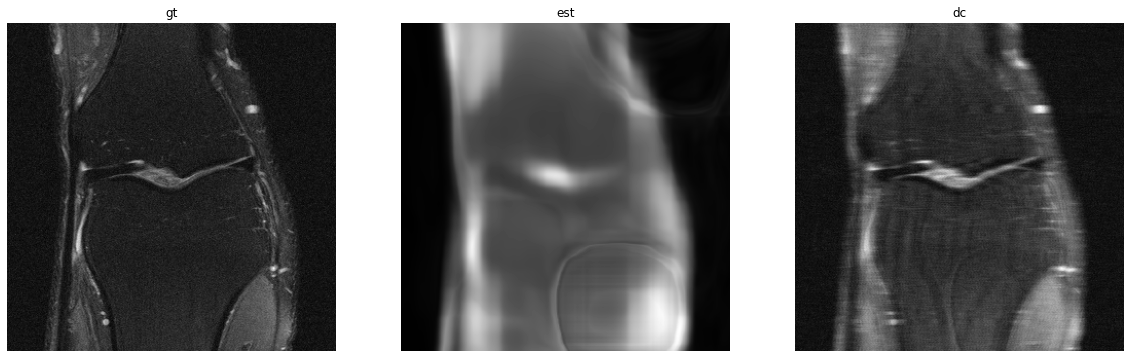

In [91]:
# when i do 0.1 * ksp_orig_
plot_list([img_gt, img_est, img_dc])

In [113]:
# when i do ksp_orig_ = 96e6 * ksp_orig, it's absolute horse shit

# TODO: why are recons wonky?
    
- this seems to be a scaling issue. see below output to tune scaling factor, then try running this over some different images
    - tuning scaling factor: takes images from awful to decent, but perhaps not quite perfect? given fine-tuning, looks like we could get it perfect

    
- are we sure it's due to scaling factor? on two samples, a manual sf fixed it. check for relationship in the modified scaling factor. i.e. maybe we can just multiply it by a constant fraction each time?


- intuition: we want ksp_orig to be scaled s.t. norm(ifft(ksp_orig)) ~= norm(out_img) created using randomly initialized weights and net_input ~U[0,1]
    - fastmri data has .mean() ~1e-9, whereas qdess data has .mean() ~3000. meanwhile net_input with randomly initialized weights will give output ~.1
    - thus scaling_factor in fastmri is ~100000000, whereas in qdess ~1e-4
    - this gives us ksp_masked which can match to size of network outputs for smooth gradient descent
    - thus in both: ksp_orig_ and ksp_masked have re(.mean()) ~.3. img_est, img_dc have .mean() ~2-3
        - note img_gt.mean() is very small in fastmri, very large in qdess
- seems like everything makes sense?
    - when i manually do scaling, what changes?


- what's not an issue
    - new way of computing scaling factor. everything thoroughly checked except for different versions of pytorch ifft_2d() v ifft2() when calculating norm(orig_img). --> very unlikely this is an issue
    - new way of computing / applying mask
    
# UPDATE Wednesday evening 20201111

- when i try doing 0.5 * ksp_orig_ ~= 48e6 * ksp_orig instead of 96e6 * ksp_orig, the results look decent for 1000 iter (see below)
    - might be hack to account for a scaling factor of 2 difference b/w old/new processing w ifft()? my guess
- but then when i tried this for 10000 iter, it seemed there were maybe some streaky vertical artifacts not present in the original fastmr runs
    - now running for 10000 iter over many samples
    - tomorrow: compare these outputs w the original for 10000 iter (quant and qual)
    - if outputs are very similar, then i hacked my way out of the bug! if not, will need to dig deeper, probably into the code for ifft()
- after all this mess, delete the old master branch i cloned

### try recon over span of scaling factors, 

i.e. from 1 --> 89630408, and see if any of the output is decent. if it's all shit, then might not be a scaling issue

### results on NUM_ITER=10000

- when multiplied by original scaling factor, output is meh
    - but previously (i.e. above) for less iter, im_est was horrible. TODO: resolve this discrepancy
- when multiplied by a manually-chosen scaling factor ~10x smaller than original, looks significantly better (but not quite perfect)
    - suggests we just need to find the correct scaling factor per the old code

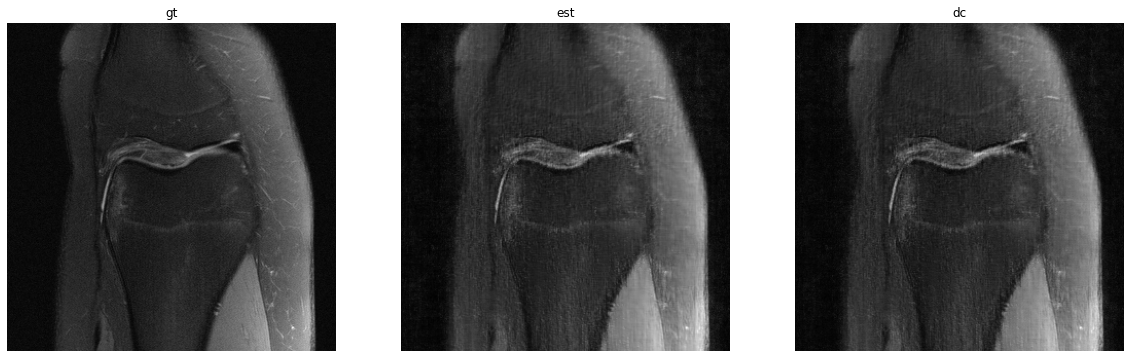

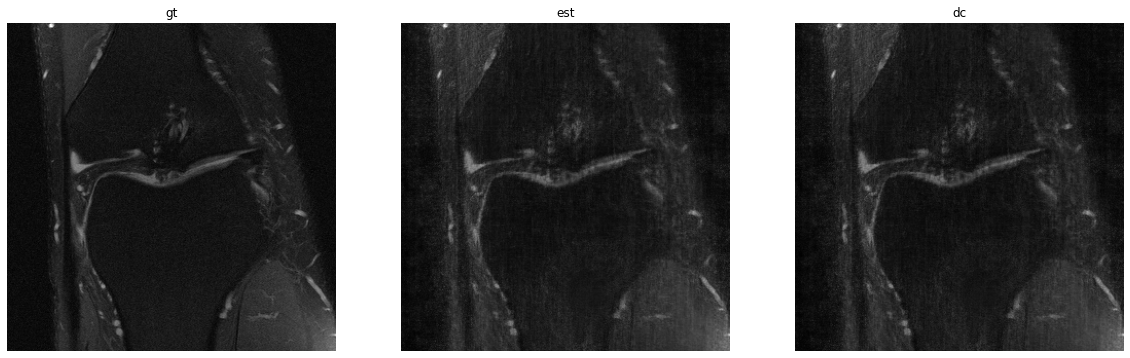

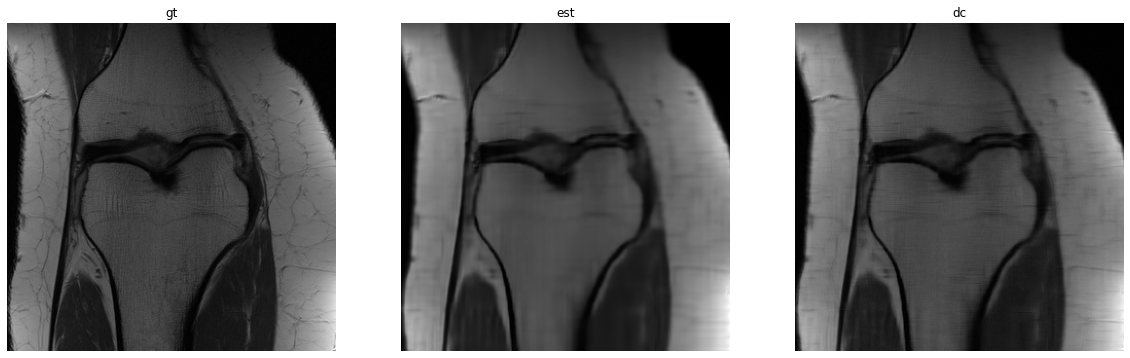

KeyboardInterrupt: 

In [150]:
dim = 320

file_id_list = ['1000273', '1000325', '1000464', '1000007', '1000537', '1000818']

for file_id in file_id_list:    

    f, ksp_orig = load_h5(file_id)
    ksp_orig = torch.from_numpy(ksp_orig)

    mask = get_mask(ksp_orig)

    net, net_input, ksp_orig_ = init_convdecoder(ksp_orig, mask)  
#     ksp_orig_ = sf * ksp_orig
    
    ksp_masked = 0.5 * ksp_orig_ * mask
    img_masked = ifft_2d(ksp_masked)
    
    net, mse_wrt_ksp, mse_wrt_img = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask2d=mask, num_iter=10000)
    
    img_out = net(net_input.type(dtype))[0]
    img_out = reshape_adj_channels_to_complex_vals(img_out)
    ksp_est = fft_2d(img_out)
    ksp_dc = torch.where(mask, ksp_masked, ksp_est) 
    
    img_est = crop_center(root_sum_squares(ifft_2d(ksp_est)).detach(), dim, dim)
    img_dc = crop_center(root_sum_squares(ifft_2d(ksp_dc)).detach(), dim, dim)
    img_gt = crop_center(root_sum_squares(ifft_2d(ksp_orig)), dim, dim)
    
    plot_list([img_gt, img_est, img_dc])